In [1]:
from functions import *

## Objective:

Cluster songs based on their lyrics

In [2]:
en_songs = pd.read_csv('data/en_songs.csv')

In [5]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(en_songs.lyrics).toarray()

## Elbow method

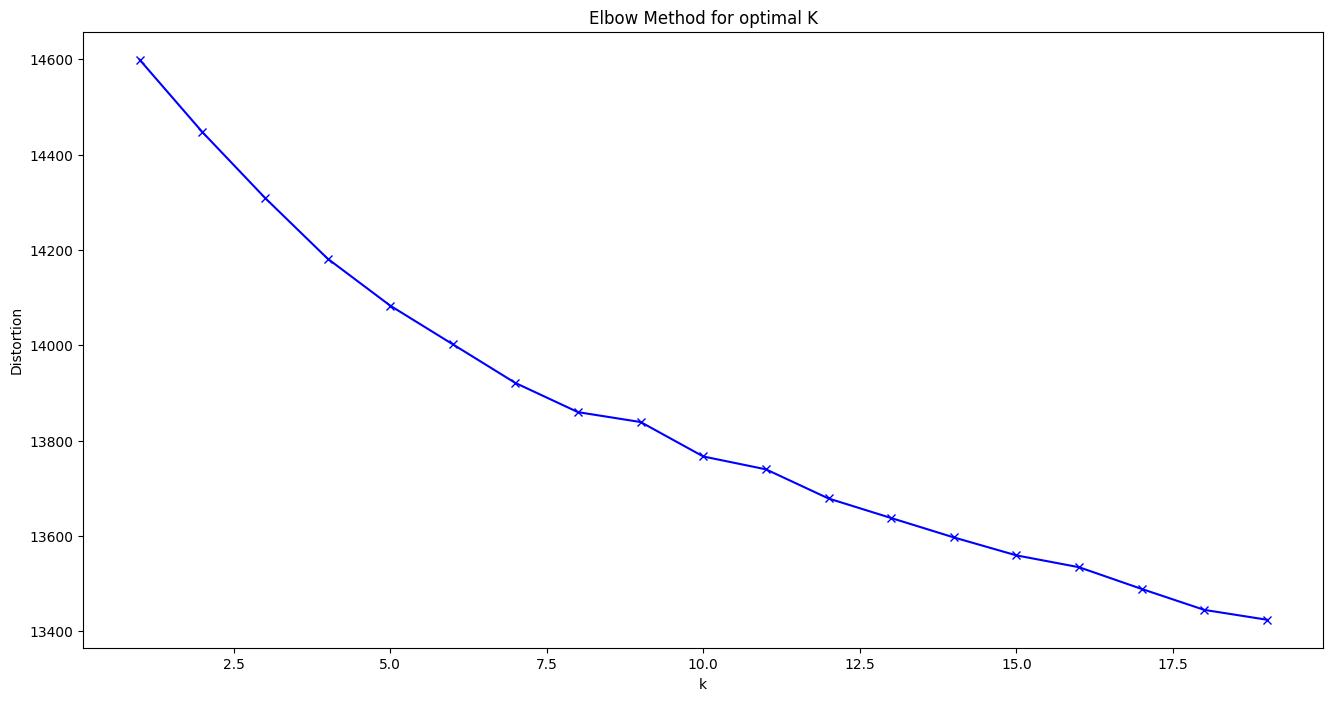

In [11]:
plot_elbow(X,1,20)

## Observation

Not sure where the elbow is at but we're gonna pick 20 because my intuition as a Data Scientist told me to.

In [18]:
true_k = 20
km = KMeans(n_clusters=true_k)
km.fit(X)

KMeans(n_clusters=20)

In [19]:
labels = km.labels_
songs_cl = pd.DataFrame(list(zip(en_songs.track_name, labels)), columns=['title','cluster'])
songs_cl.cluster.value_counts()

17    4604
1     3163
5     1409
0      898
14     697
2      630
7      597
4      588
16     576
13     365
11     362
3      270
15     256
8      244
18     163
9      161
12     136
19     131
10      92
6       63
Name: cluster, dtype: int64

In [20]:
songs_cl

,title,cluster
0,I Feel Alive,8
1,Poison,17
2,Baby It's Cold Outside (feat. Christina Aguilera),14
3,Dumb Litty,17
4,Soldier,16
...,...,...
15400,Some Way,5
15401,Rising Like The Sun - Radio Mix,1
15402,Anaconda,5
15403,Bound,0


In [21]:
en_songs['cluster_label'] = songs_cl['cluster']

In [22]:
en_songs2 = en_songs.copy()

In [23]:
en_songs2.to_csv('data/en_songs2.csv', index=False)